## BPNN

In [ ]:
import time
import numpy
from math import sqrt
from numpy import concatenate
import numpy as np
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout
from keras.layers import LSTM,SimpleRNN,GRU,Bidirectional
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]


    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
dataset = read_csv('/content/Ulsoordata.csv', header=0, usecols=[6])  
values = dataset.values
values = values.astype('float32')  
scaler = MinMaxScaler(feature_range=(0, 1))    
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1) 
values = reframed.values
threshold = int(0.87 * len(reframed))
train = values[:threshold, :]
test = values[threshold:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
regressorBKP = Sequential()
regressorBKP.add(Dense(units = 500, kernel_initializer = 'uniform',  input_dim = 1))
regressorBKP.add(Dropout(0.2))
regressorBKP.add(Dense(units = 500, kernel_initializer = 'uniform'))
regressorBKP.add(Dropout(0.2))
regressorBKP.add(Dense(units = 500, kernel_initializer = 'uniform'))
regressorBKP.add(Dropout(0.2))
regressorBKP.add(Dense(units = 500, kernel_initializer = 'uniform'))
regressorBKP.add(Dropout(0.2))
regressorBKP.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
regressorBKP.compile(optimizer = 'adam', loss = 'mean_squared_error')
start = time.time()
print("Compilation Time : ", time.time() - start)

history = regressorBKP.fit(train_X, train_y, epochs = 200, batch_size = 32 ,validation_data=(test_X, test_y), verbose=1,
                    shuffle=False)


Compilation Time :  3.910064697265625e-05
Epoch 1/200
20/20 [==============================] - 1s 21ms/step - loss: 0.0574 - val_loss: 0.0075
Epoch 2/200
20/20 [==============================] - 0s 13ms/step - loss: 0.0576 - val_loss: 0.0057
Epoch 3/200
20/20 [==============================] - 0s 12ms/step - loss: 0.0076 - val_loss: 0.0023
Epoch 4/200
20/20 [==============================] - 0s 13ms/step - loss: 0.0105 - val_loss: 0.0032
Epoch 5/200
20/20 [==============================] - 0s 13ms/step - loss: 0.0162 - val_loss: 0.0013
Epoch 6/200
20/20 [==============================] - 0s 13ms/step - loss: 0.0121 - val_loss: 0.0011
Epoch 7/200
20/20 [==============================] - 0s 13ms/step - loss: 0.0094 - val_loss: 0.0016
Epoch 8/200
20/20 [==============================] - 0s 14ms/step - loss: 0.0081 - val_loss: 8.0220e-04
Epoch 9/200
20/20 [==============================] - 0s 13ms/step - loss: 0.0075 - val_loss: 0.0012
Epoch 10/200
20/20 [==============================] - 

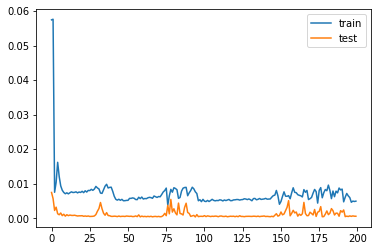

In [ ]:
pyplot.figure(2)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


In [ ]:
train_xhat=regressorBKP.predict(train_X)
yhat = regressorBKP.predict(test_X)

In [ ]:
trainPredict = scaler.inverse_transform(train_xhat)
train_yhat = scaler.inverse_transform([train_y])
testPredict = scaler.inverse_transform(yhat)
test_yhat = scaler.inverse_transform([test_y])

In [ ]:
look_back= 1

trainPredictPlot = numpy.empty_like(scaled)    
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

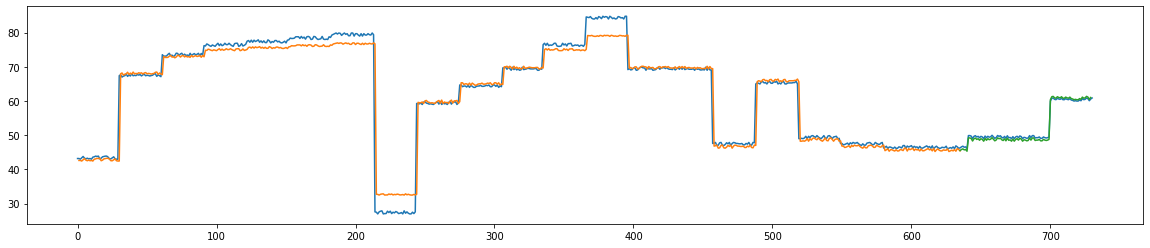

In [ ]:
testPredictPlot = numpy.empty_like(scaled)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict):len(scaled)-1, :] = testPredict
pyplot.figure(figsize = (20, 4))
pyplot.plot(scaler.inverse_transform(scaled))
pyplot.plot(trainPredictPlot)
pyplot.plot(testPredictPlot)
pyplot.show()

In [ ]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test Score: %.4f RMSE' % rmse)
test2 = np.abs(mean_squared_error(inv_y, inv_yhat)).mean()
print('Test Score: %.4f MAE' % (test2))
test = np.mean(np.abs(mean_squared_error(inv_y, inv_yhat) / inv_y))
print('Test Score: %.4f MAPE' % (test))

Test Score: 1.4417 RMSE
Test Score: 2.0786 MAE
Test Score: 0.0397 MAPE


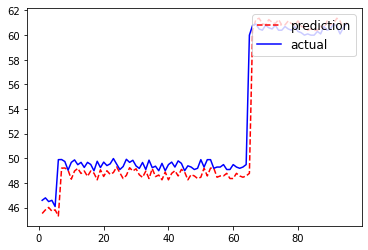

In [ ]:
pyplot.plot([x for x in range(1, inv_yhat.shape[0]+1)], inv_yhat, linestyle='--', color='red', label='prediction')
pyplot.plot([x for x in range(1, inv_y.shape[0]+1)], inv_y, linestyle='-', color='blue', label='actual')
pyplot.legend(loc=1, prop={'size': 12})
pyplot.show()

## SVR

In [ ]:
from math import sqrt
from numpy import concatenate
import numpy as np
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from matplotlib import pyplot

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [ ]:
dataset = read_csv('/content/Ulsoordata.csv', header=0, usecols=[6])  
values = dataset.values
values = values.astype('float32')  
scaler = MinMaxScaler(feature_range=(0, 1))    
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1) 
values = reframed.values
threshold = int(0.87 * len(reframed))
train = values[:threshold, :]
test = values[threshold:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [ ]:
clf = SVR(C=1.0, kernel='sigmoid', degree=3, gamma = 0.1, max_iter=10000)

clf.fit(train_X,train_y)

# make a prediction
predict_y = clf.predict(test_X)
yhat = predict_y.reshape(predict_y.shape[0],1)
test_X = test_X.reshape((test_X.shape[0],test_X.shape[1]))
print(yhat.shape,test_X.shape)
# invert scaling for forecast
inv_yhat = concatenate((test_X[:, -24:-1], yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_X[:, -24:-1], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.4f' % rmse)
mae = np.abs(mean_squared_error(inv_y, inv_yhat)).mean()
print('Test Score: %.4f MAE' % (mae))
mape = np.mean(np.abs(mean_squared_error(inv_y, inv_yhat) / inv_y))
print('Test Score: %.4f MAPE' % (mape))


(95, 1) (95, 1)
Test RMSE: 1.6040
Test Score: 2.5727 MAE
Test Score: 0.0491 MAPE


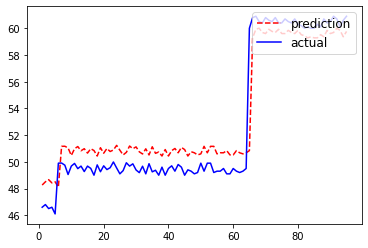

In [ ]:
pyplot.plot([x for x in range(1, inv_yhat.shape[0]+1)], inv_yhat, linestyle='--', color='red', label='prediction')
pyplot.plot([x for x in range(1, inv_y.shape[0]+1)], inv_y, linestyle='-', color='blue', label='actual')
pyplot.legend(loc=1, prop={'size': 12})
pyplot.show()

## SRN

In [ ]:
import time
import numpy
from math import sqrt
from numpy import concatenate
import numpy as np
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout
from keras.layers import LSTM,SimpleRNN
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]


    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
dataset = read_csv('/content/Ulsoordata.csv', header=0, usecols=[6])  #header 第一列为编号  index_col为取索引的参数
values = dataset.values
values = values.astype('float32')  #转化为浮点型
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))    #归一化处理
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)  #转化为监督学习  设计预测维数
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[5,6,7]], axis=1, inplace=True) #reframed.drop 删除不预测的列
print(reframed.head())
values = reframed.values
threshold = int(0.87 * len(reframed))
train = values[:threshold, :]
test = values[threshold:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
model = Sequential()
model.add(SimpleRNN(units = 500, return_sequences = True, input_shape = (train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(SimpleRNN(units = 500, return_sequences = True))
model.add(Dropout(0.2))
model.add(SimpleRNN(units = 500, return_sequences = True))
model.add(Dropout(0.2))
model.add(SimpleRNN(units = 500, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units = 1,activation = 'sigmoid'))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
start = time.time()
print("Compilation Time : ", time.time() - start)

history = model.fit(train_X, train_y, epochs = 200, batch_size = 32 ,validation_data=(test_X, test_y), verbose=1,
                    shuffle=False)


   var1(t-1)   var1(t)
1   0.280277  0.280277
2   0.280277  0.276817
3   0.276817  0.283737
4   0.283737  0.290657
5   0.290657  0.282007
Compilation Time :  3.8623809814453125e-05
Epoch 1/200
20/20 [==============================] - 4s 54ms/step - loss: 0.0967 - val_loss: 0.0213
Epoch 2/200
20/20 [==============================] - 1s 26ms/step - loss: 0.0672 - val_loss: 0.0302
Epoch 3/200
20/20 [==============================] - 1s 26ms/step - loss: 0.0493 - val_loss: 0.0089
Epoch 4/200
20/20 [==============================] - 1s 27ms/step - loss: 0.0075 - val_loss: 6.8330e-04
Epoch 5/200
20/20 [==============================] - 1s 26ms/step - loss: 0.0073 - val_loss: 0.0013
Epoch 6/200
20/20 [==============================] - 1s 27ms/step - loss: 0.0103 - val_loss: 0.0016
Epoch 7/200
20/20 [==============================] - 1s 26ms/step - loss: 0.0099 - val_loss: 8.5739e-04
Epoch 8/200
20/20 [==============================] - 1s 27ms/step - loss: 0.0060 - val_loss: 7.6843e-04
Epoch 9

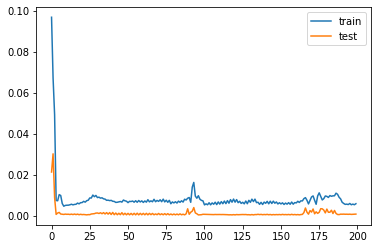

In [ ]:
pyplot.figure(2)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


In [ ]:
train_xhat=model.predict(train_X)
yhat = model.predict(test_X)

In [ ]:
trainPredict = scaler.inverse_transform(train_xhat)
train_yhat = scaler.inverse_transform([train_y])
testPredict = scaler.inverse_transform(yhat)
test_yhat = scaler.inverse_transform([test_y])

In [ ]:
look_back= 1

trainPredictPlot = numpy.empty_like(scaled)    
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

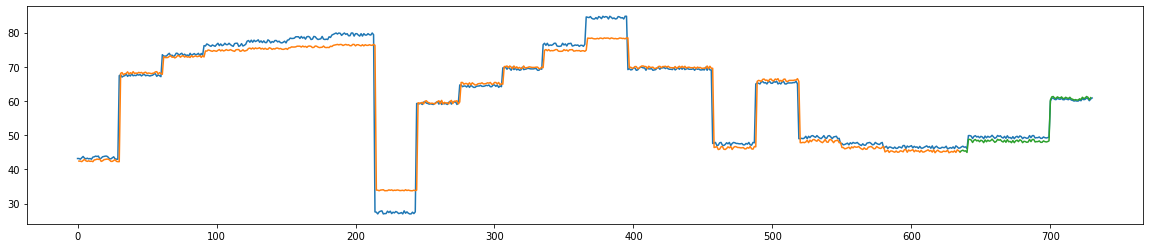

In [ ]:
testPredictPlot = numpy.empty_like(scaled)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict):len(scaled)-1, :] = testPredict
pyplot.figure(figsize = (20, 4))
pyplot.plot(scaler.inverse_transform(scaled))
pyplot.plot(trainPredictPlot)
pyplot.plot(testPredictPlot)
pyplot.show()

In [ ]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test Score: %.4f RMSE' % rmse)
test2 = np.abs(mean_squared_error(inv_y, inv_yhat)).mean()
print('Test Score: %.4f MAE' % (test2))
test = np.mean(np.abs(mean_squared_error(inv_y, inv_yhat) / inv_y))
print('Test Score: %.4f MAPE' % (test))

Test Score: 1.6534 RMSE
Test Score: 2.7337 MAE
Test Score: 0.0522 MAPE


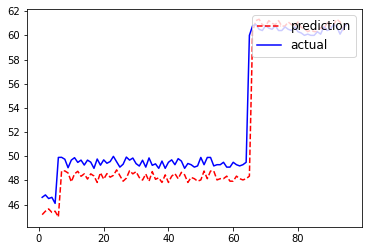

In [ ]:
pyplot.plot([x for x in range(1, inv_yhat.shape[0]+1)], inv_yhat, linestyle='--', color='red', label='prediction')
pyplot.plot([x for x in range(1, inv_y.shape[0]+1)], inv_y, linestyle='-', color='blue', label='actual')
pyplot.legend(loc=1, prop={'size': 12})
pyplot.show()

#LSTM

In [ ]:
import time
import numpy
from math import sqrt
from numpy import concatenate
import numpy as np
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout
from keras.layers import LSTM,SimpleRNN,GRU,Bidirectional
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]


    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
dataset = read_csv('/content/Ulsoordata.csv', header=0, usecols=[6])  #header 第一列为编号  index_col为取索引的参数
values = dataset.values
values = values.astype('float32')  #转化为浮点型
scaler = MinMaxScaler(feature_range=(0, 1))    #归一化处理
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)  #转化为监督学习  设计预测维数
values = reframed.values
threshold = int(0.87 * len(reframed))
train = values[:threshold, :]
test = values[threshold:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
regressor = Sequential()
regressor.add(LSTM(units = 500, return_sequences = True, input_shape = (train_X.shape[1],train_X.shape[2])))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 500, return_sequences = True ))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 500, return_sequences = True ))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 500, return_sequences=False ))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1,activation = 'sigmoid'))
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
start = time.time()
print("Compilation Time : ", time.time() - start)

history = regressor.fit(train_X, train_y, epochs = 200, batch_size = 32 ,validation_data=(test_X, test_y), verbose=1,
                    shuffle=False)


Compilation Time :  3.814697265625e-05
Epoch 1/200
20/20 [==============================] - 10s 166ms/step - loss: 0.0814 - val_loss: 0.0169
Epoch 2/200
20/20 [==============================] - 2s 81ms/step - loss: 0.0776 - val_loss: 0.0425
Epoch 3/200
20/20 [==============================] - 2s 81ms/step - loss: 0.0608 - val_loss: 0.0362
Epoch 4/200
20/20 [==============================] - 2s 81ms/step - loss: 0.0379 - val_loss: 0.0091
Epoch 5/200
20/20 [==============================] - 2s 81ms/step - loss: 0.0130 - val_loss: 0.0028
Epoch 6/200
20/20 [==============================] - 2s 80ms/step - loss: 0.0042 - val_loss: 5.0140e-04
Epoch 7/200
20/20 [==============================] - 2s 79ms/step - loss: 0.0043 - val_loss: 8.9988e-04
Epoch 8/200
20/20 [==============================] - 2s 82ms/step - loss: 0.0043 - val_loss: 8.9448e-04
Epoch 9/200
20/20 [==============================] - 2s 81ms/step - loss: 0.0046 - val_loss: 9.2384e-04
Epoch 10/200
20/20 [=======================

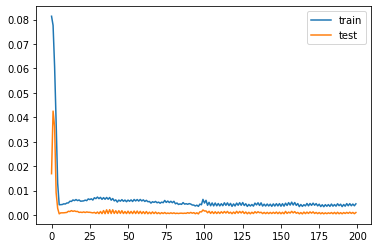

In [ ]:
pyplot.figure(2)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


In [ ]:
train_xhat=regressor.predict(train_X)
yhat = regressor.predict(test_X)

In [ ]:
trainPredict = scaler.inverse_transform(train_xhat)
train_yhat = scaler.inverse_transform([train_y])
testPredict = scaler.inverse_transform(yhat)
test_yhat = scaler.inverse_transform([test_y])

In [ ]:
look_back=1

trainPredictPlot = numpy.empty_like(scaled)    
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

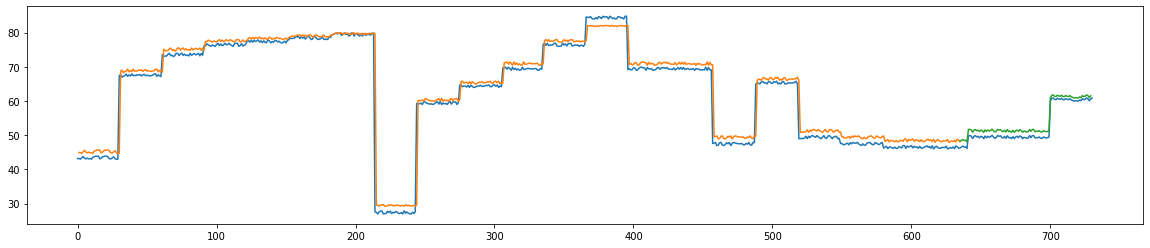

In [ ]:
testPredictPlot = numpy.empty_like(scaled)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict):len(scaled)-1, :] = testPredict
pyplot.figure(figsize = (20, 4))
pyplot.plot(scaler.inverse_transform(scaled))
pyplot.plot(trainPredictPlot)
pyplot.plot(testPredictPlot)
pyplot.show()

In [ ]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test Score: %.4f RMSE' % rmse)
test2 = np.abs(mean_squared_error(inv_y, inv_yhat)).mean()
print('Test Score: %.4f MAE' % (test2))
test = np.mean(np.abs(mean_squared_error(inv_y, inv_yhat) / inv_y))
print('Test Score: %.4f MAPE' % (test))

Test Score: 1.8634 RMSE
Test Score: 3.4722 MAE
Test Score: 0.0663 MAPE


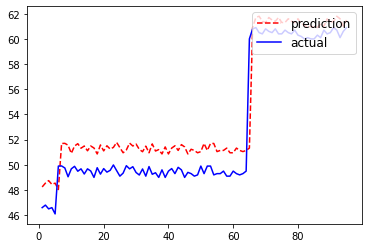

In [ ]:
pyplot.plot([x for x in range(1, inv_yhat.shape[0]+1)], inv_yhat, linestyle='--', color='red', label='prediction')
pyplot.plot([x for x in range(1, inv_y.shape[0]+1)], inv_y, linestyle='-', color='blue', label='actual')
pyplot.legend(loc=1, prop={'size': 12})
pyplot.show()

#GRU

In [ ]:
import time
import numpy
from math import sqrt
from numpy import concatenate
import numpy as np
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout
from keras.layers import LSTM,SimpleRNN,GRU,Bidirectional
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]


    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
dataset = read_csv('/content/Ulsoordata.csv', header=0, usecols=[6])  #header 第一列为编号  index_col为取索引的参数
values = dataset.values
values = values.astype('float32')  #转化为浮点型
scaler = MinMaxScaler(feature_range=(0, 1))    #归一化处理
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)  #转化为监督学习  设计预测维数
values = reframed.values
threshold = int(0.87 * len(reframed))
train = values[:threshold, :]
test = values[threshold:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
regressorGRU = Sequential()
regressorGRU.add(GRU(units=500, return_sequences=True, input_shape=(train_X.shape[1],train_X.shape[2])))
regressorGRU.add(Dropout(0.2))
regressorGRU.add(GRU(units=500, return_sequences=True))
regressorGRU.add(Dropout(0.2))
regressorGRU.add(GRU(units=500, return_sequences=True))
regressorGRU.add(Dropout(0.2))
regressorGRU.add(GRU(units=500,return_sequences=False))
regressorGRU.add(Dropout(0.2))
regressorGRU.add(Dense(units=1,activation = 'sigmoid'))
regressorGRU.compile(optimizer = 'adam', loss = 'mean_squared_error')
start = time.time()
print("Compilation Time : ", time.time() - start)

history = regressorGRU.fit(train_X, train_y, epochs = 200, batch_size = 32 ,validation_data=(test_X, test_y), verbose=1,
                    shuffle=False)


Compilation Time :  3.933906555175781e-05
Epoch 1/200
20/20 [==============================] - 11s 145ms/step - loss: 0.0838 - val_loss: 0.0222
Epoch 2/200
20/20 [==============================] - 1s 64ms/step - loss: 0.0699 - val_loss: 0.0200
Epoch 3/200
20/20 [==============================] - 1s 63ms/step - loss: 0.0201 - val_loss: 0.0050
Epoch 4/200
20/20 [==============================] - 1s 64ms/step - loss: 0.0134 - val_loss: 0.0012
Epoch 5/200
20/20 [==============================] - 1s 65ms/step - loss: 0.0132 - val_loss: 8.7062e-04
Epoch 6/200
20/20 [==============================] - 1s 64ms/step - loss: 0.0114 - val_loss: 0.0019
Epoch 7/200
20/20 [==============================] - 1s 64ms/step - loss: 0.0127 - val_loss: 0.0026
Epoch 8/200
20/20 [==============================] - 1s 63ms/step - loss: 0.0090 - val_loss: 0.0013
Epoch 9/200
20/20 [==============================] - 1s 64ms/step - loss: 0.0113 - val_loss: 0.0038
Epoch 10/200
20/20 [==============================] 

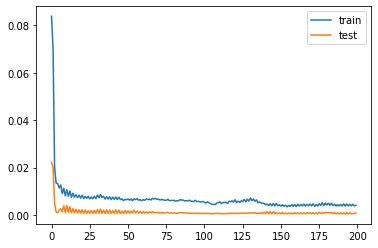

In [ ]:
pyplot.figure(2)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


In [ ]:
train_xhat=regressorGRU.predict(train_X)
yhat = regressorGRU.predict(test_X)

In [ ]:
trainPredict = scaler.inverse_transform(train_xhat)
train_yhat = scaler.inverse_transform([train_y])
testPredict = scaler.inverse_transform(yhat)
test_yhat = scaler.inverse_transform([test_y])

In [ ]:
look_back=1

trainPredictPlot = numpy.empty_like(scaled)    
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

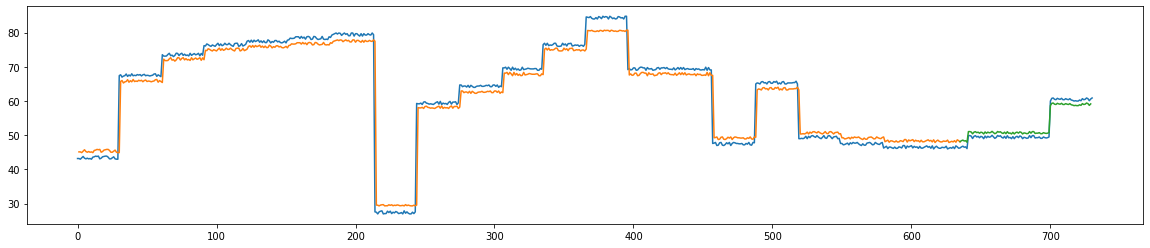

In [ ]:
testPredictPlot = numpy.empty_like(scaled)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict):len(scaled)-1, :] = testPredict
pyplot.figure(figsize = (20, 4))
pyplot.plot(scaler.inverse_transform(scaled))
pyplot.plot(trainPredictPlot)
pyplot.plot(testPredictPlot)
pyplot.show()

In [ ]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test Score: %.4f RMSE' % rmse)
test2 = np.abs(mean_squared_error(inv_y, inv_yhat)).mean()
print('Test Score: %.4f MAE' % (test2))
test = np.mean(np.abs(mean_squared_error(inv_y, inv_yhat) / inv_y))
print('Test Score: %.4f MAPE' % (test))

Test Score: 1.6998 RMSE
Test Score: 2.8893 MAE
Test Score: 0.0551 MAPE


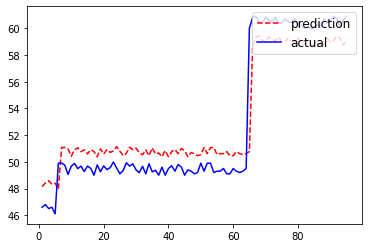

In [ ]:
pyplot.plot([x for x in range(1, inv_yhat.shape[0]+1)], inv_yhat, linestyle='--', color='red', label='prediction')
pyplot.plot([x for x in range(1, inv_y.shape[0]+1)], inv_y, linestyle='-', color='blue', label='actual')
pyplot.legend(loc=1, prop={'size': 12})
pyplot.show()

#BiLSTM

In [ ]:
import time
import numpy
from math import sqrt
from numpy import concatenate
import numpy as np
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout
from keras.layers import LSTM,SimpleRNN,GRU,Bidirectional
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]


    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
dataset = read_csv('/content/Ulsoordata.csv', header=0, usecols=[6])  
values = dataset.values
values = values.astype('float32')  
scaler = MinMaxScaler(feature_range=(0, 1))    
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1) 
values = reframed.values
threshold = int(0.87 * len(reframed))
train = values[:threshold, :]
test = values[threshold:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
regressorBilstm = Sequential()
regressorBilstm.add(Bidirectional(LSTM(units = 500, return_sequences = True, input_shape = (train_X.shape[1], train_X.shape[2]))))
regressorBilstm.add(Dropout(0.2))
regressorBilstm.add(Bidirectional(LSTM(units = 500, return_sequences = True)))
regressorBilstm.add(Dropout(0.2))
regressorBilstm.add(Bidirectional(LSTM(units = 500, return_sequences = True)))
regressorBilstm.add(Dropout(0.2))
regressorBilstm.add(Bidirectional(LSTM(units = 500 ,return_sequences=False)))
regressorBilstm.add(Dropout(0.2))
regressorBilstm.add(Dense(units = 1,activation = 'sigmoid'))
regressorBilstm.compile(optimizer = 'adam', loss = 'mean_squared_error')
start = time.time()
print("Compilation Time : ", time.time() - start)

history = regressorBilstm.fit(train_X, train_y, epochs = 200, batch_size = 32 ,validation_data=(test_X, test_y), verbose=1,
                    shuffle=False)


Compilation Time :  3.7670135498046875e-05
Epoch 1/200
20/20 [==============================] - 25s 404ms/step - loss: 0.0842 - val_loss: 0.0247
Epoch 2/200
20/20 [==============================] - 4s 216ms/step - loss: 0.0725 - val_loss: 0.0321
Epoch 3/200
20/20 [==============================] - 4s 221ms/step - loss: 0.0498 - val_loss: 0.0110
Epoch 4/200
20/20 [==============================] - 4s 220ms/step - loss: 0.0130 - val_loss: 0.0012
Epoch 5/200
20/20 [==============================] - 4s 223ms/step - loss: 0.0101 - val_loss: 0.0020
Epoch 6/200
20/20 [==============================] - 4s 222ms/step - loss: 0.0091 - val_loss: 0.0022
Epoch 7/200
20/20 [==============================] - 4s 216ms/step - loss: 0.0070 - val_loss: 8.2852e-04
Epoch 8/200
20/20 [==============================] - 4s 218ms/step - loss: 0.0084 - val_loss: 0.0031
Epoch 9/200
20/20 [==============================] - 4s 214ms/step - loss: 0.0069 - val_loss: 9.8177e-04
Epoch 10/200
20/20 [===================

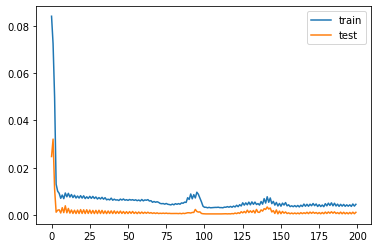

In [ ]:
pyplot.figure(2)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


In [ ]:
train_xhat=regressorBilstm.predict(train_X)
yhat = regressorBilstm.predict(test_X)

In [ ]:
trainPredict = scaler.inverse_transform(train_xhat)
train_yhat = scaler.inverse_transform([train_y])
testPredict = scaler.inverse_transform(yhat)
test_yhat = scaler.inverse_transform([test_y])

In [ ]:
look_back=1

trainPredictPlot = numpy.empty_like(scaled)    
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

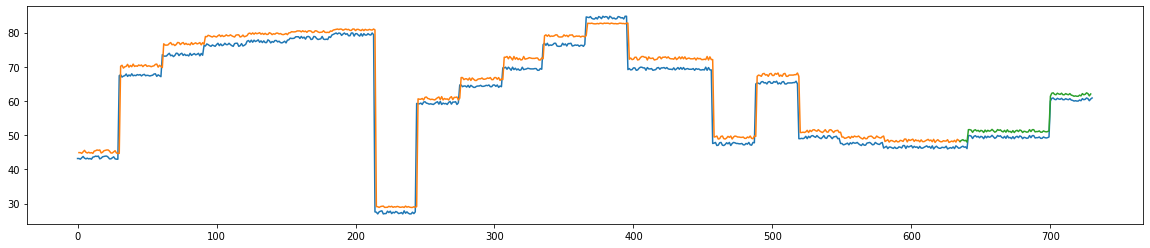

In [ ]:
testPredictPlot = numpy.empty_like(scaled)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict):len(scaled)-1, :] = testPredict
pyplot.figure(figsize = (20, 4))
pyplot.plot(scaler.inverse_transform(scaled))
pyplot.plot(trainPredictPlot)
pyplot.plot(testPredictPlot)
pyplot.show()

In [ ]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test Score: %.4f RMSE' % rmse)
test2 = np.abs(mean_squared_error(inv_y, inv_yhat)).mean()
print('Test Score: %.4f MAE' % (test2))
test = np.mean(np.abs(mean_squared_error(inv_y, inv_yhat) / inv_y))
print('Test Score: %.4f MAPE' % (test))

Test Score: 1.9348 RMSE
Test Score: 3.7433 MAE
Test Score: 0.0714 MAPE


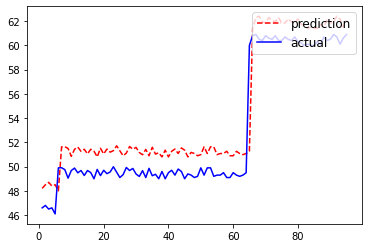

In [ ]:
pyplot.plot([x for x in range(1, inv_yhat.shape[0]+1)], inv_yhat, linestyle='--', color='red', label='prediction')
pyplot.plot([x for x in range(1, inv_y.shape[0]+1)], inv_y, linestyle='-', color='blue', label='actual')
pyplot.legend(loc=1, prop={'size': 12})
pyplot.show()

## Improved RNN

In [ ]:
import time
import numpy
from math import sqrt
from numpy import concatenate
import numpy as np
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout
from keras.layers import LSTM,SimpleRNN,GRU,Bidirectional
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]


    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
dataset = read_csv('/content/Ulsoordata.csv', header=0, usecols=[6])  
values = dataset.values
values = values.astype('float32')  
scaler = MinMaxScaler(feature_range=(0, 1))    
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1) 
values = reframed.values
threshold = int(0.87 * len(reframed))
train = values[:threshold, :]
test = values[threshold:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
regressorIMRNN = Sequential()
regressorIMRNN.add((SimpleRNN(units = 500, return_sequences = True, input_shape = (train_X.shape[1], train_X.shape[2]))))
regressorIMRNN.add(Dropout(0.2))
regressorIMRNN.add((SimpleRNN(units = 500, return_sequences = True)))
regressorIMRNN.add(Dropout(0.2))
regressorIMRNN.add((LSTM(units = 500, return_sequences = True )))
regressorIMRNN.add(Dropout(0.2))
regressorIMRNN.add((LSTM(units = 500, return_sequences = True)))
regressorIMRNN.add(Dropout(0.2))
regressorIMRNN.add((GRU(units = 500, return_sequences = True )))
regressorIMRNN.add(Dropout(0.2))
regressorIMRNN.add((GRU(units = 500, return_sequences = True)))
regressorIMRNN.add(Dropout(0.2))
regressorIMRNN.add((SimpleRNN(units = 500, return_sequences = False)))
regressorIMRNN.add(Dropout(0.2))
regressorIMRNN.add(Dense(units = 1,activation = 'sigmoid'))
regressorIMRNN.compile(optimizer = 'adam', loss = 'mean_squared_error')
start = time.time()
print("Compilation Time : ", time.time() - start)

history = regressorIMRNN.fit(train_X, train_y, epochs = 200, batch_size = 32 ,validation_data=(test_X, test_y), verbose=1,
                    shuffle=False)


Compilation Time :  5.435943603515625e-05
Epoch 1/200
20/20 [==============================] - 13s 220ms/step - loss: 0.0882 - val_loss: 0.0167
Epoch 2/200
20/20 [==============================] - 2s 94ms/step - loss: 0.0820 - val_loss: 0.0338
Epoch 3/200
20/20 [==============================] - 2s 94ms/step - loss: 0.0721 - val_loss: 0.0186
Epoch 4/200
20/20 [==============================] - 2s 96ms/step - loss: 0.0630 - val_loss: 0.0148
Epoch 5/200
20/20 [==============================] - 2s 97ms/step - loss: 0.0185 - val_loss: 0.0196
Epoch 6/200
20/20 [==============================] - 2s 96ms/step - loss: 0.0174 - val_loss: 0.0037
Epoch 7/200
20/20 [==============================] - 2s 96ms/step - loss: 0.0196 - val_loss: 0.0052
Epoch 8/200
20/20 [==============================] - 2s 96ms/step - loss: 0.0221 - val_loss: 0.0102
Epoch 9/200
20/20 [==============================] - 2s 95ms/step - loss: 0.0240 - val_loss: 0.0050
Epoch 10/200
20/20 [==============================] - 2s

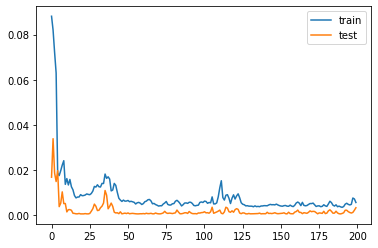

In [ ]:
pyplot.figure(2)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


In [ ]:
train_xhat=regressorIMRNN.predict(train_X)
yhat = regressorIMRNN.predict(test_X)

In [ ]:
trainPredict = scaler.inverse_transform(train_xhat)
train_yhat = scaler.inverse_transform([train_y])
testPredict = scaler.inverse_transform(yhat)
test_yhat = scaler.inverse_transform([test_y])

In [ ]:
look_back=1

trainPredictPlot = numpy.empty_like(scaled)    
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

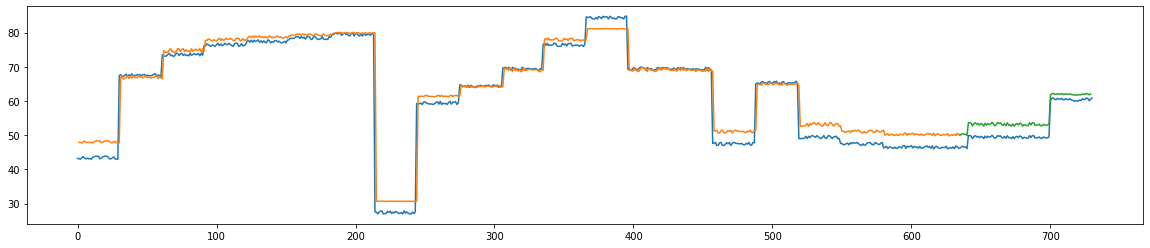

In [ ]:
testPredictPlot = numpy.empty_like(scaled)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict):len(scaled)-1, :] = testPredict
pyplot.figure(figsize = (20, 4))
pyplot.plot(scaler.inverse_transform(scaled))
pyplot.plot(trainPredictPlot)
pyplot.plot(testPredictPlot)
pyplot.show()

In [ ]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test Score: %.4f RMSE' % rmse)
test2 = np.abs(mean_squared_error(inv_y, inv_yhat)).mean()
print('Test Score: %.4f MAE' % (test2))
test = np.mean(np.abs(mean_squared_error(inv_y, inv_yhat) / inv_y))
print('Test Score: %.4f MAPE' % (test))

Test Score: 3.2495 RMSE
Test Score: 10.5594 MAE
Test Score: 0.2015 MAPE


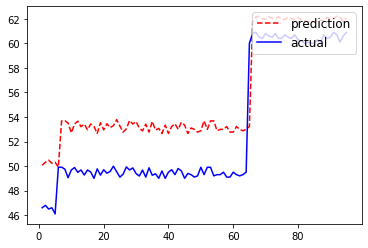

In [ ]:
pyplot.plot([x for x in range(1, inv_yhat.shape[0]+1)], inv_yhat, linestyle='--', color='red', label='prediction')
pyplot.plot([x for x in range(1, inv_y.shape[0]+1)], inv_y, linestyle='-', color='blue', label='actual')
pyplot.legend(loc=1, prop={'size': 12})
pyplot.show()